# **Agent**

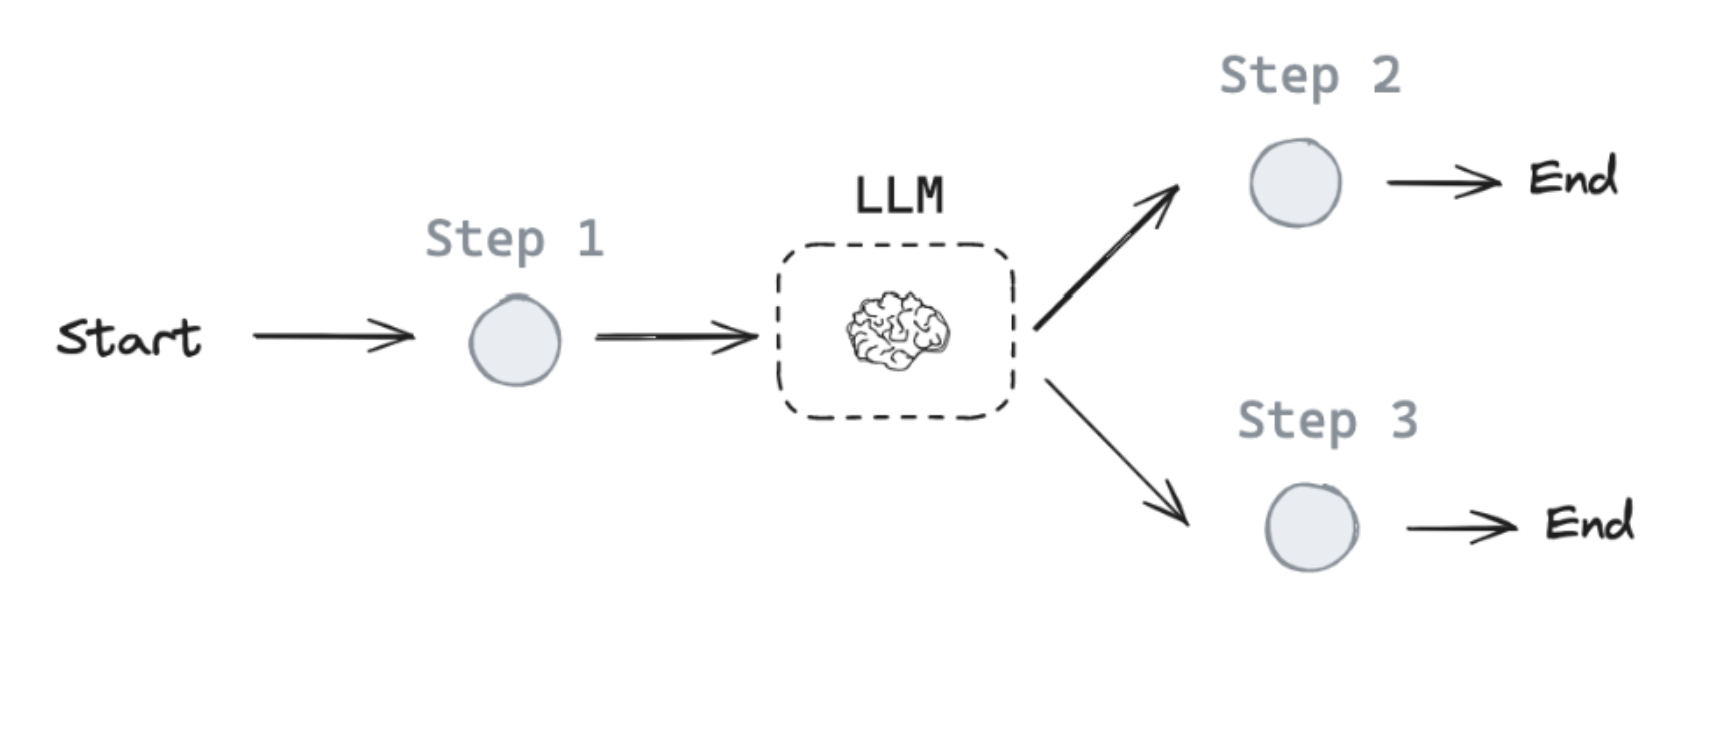

Now, we can extend this into a generic agent architecture.

In the above router, we invoked the model and, if it chose to call a tool, we returned a ToolMessage to the user.

But, what if we simply pass that ToolMessage back to the model?

We can let it either (1) call another tool or (2) respond directly.

This is the intuition behind ReAct, a general agent architecture.

act - let the model call specific tools
observe - pass the tool output back to the model
reason - let the model reason about the tool output to decide what to do next (e.g., call another tool or just respond directly)
This general purpose architecture can be applied to many types of tools.

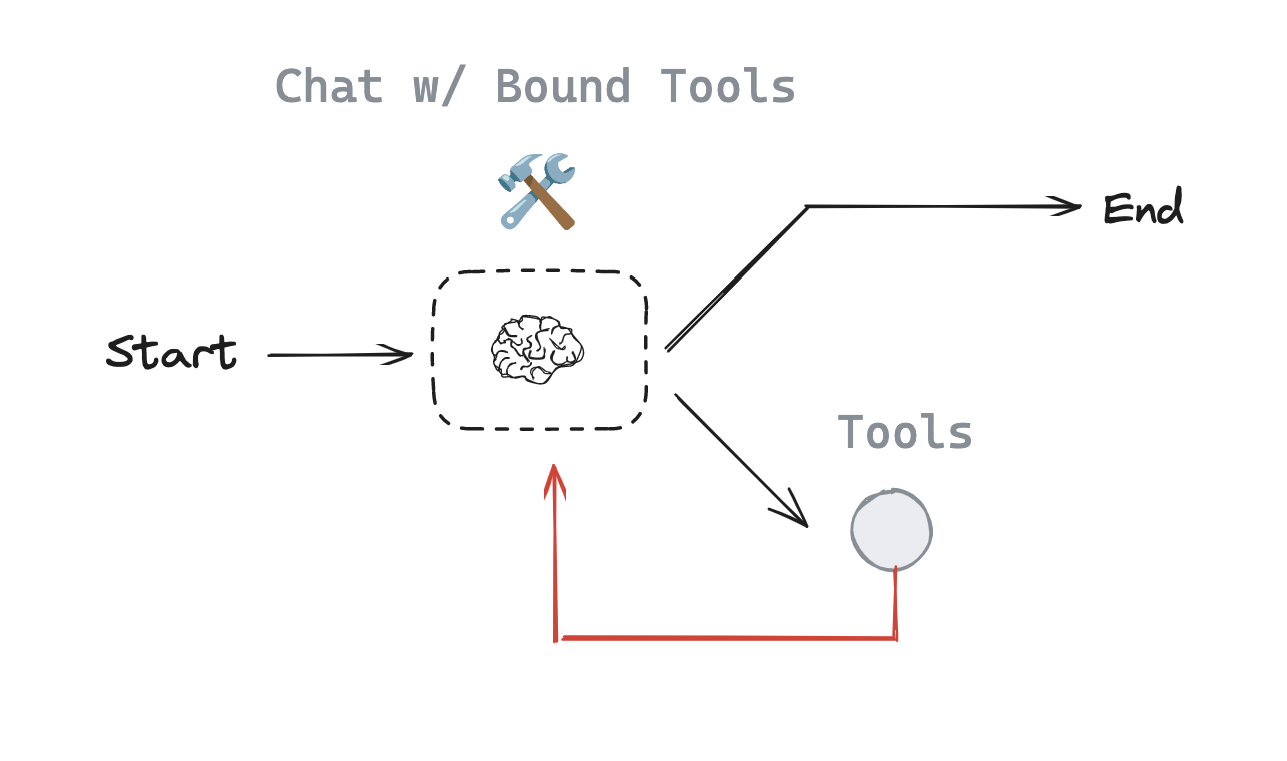

In [16]:
%%capture --no-stderr
%pip install --quiet -U langchain_google_genai langchain_core langgraph

In [17]:
import os
from google.colab import userdata
GOOGLE_API_KEY = userdata.get('GOOGLE_API_KEY')
os.environ["GOOGLE_API_KEY"]=GOOGLE_API_KEY

In [18]:
from langchain_google_genai import ChatGoogleGenerativeAI
model = ChatGoogleGenerativeAI(model="gemini-2.0-flash")
model.invoke("Hello")

AIMessage(content='Hello there! How can I help you today?', additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': []}, id='run-d39cc9f7-5cda-4ea5-a0e4-dd4f759b7ea1-0', usage_metadata={'input_tokens': 1, 'output_tokens': 11, 'total_tokens': 12, 'input_token_details': {'cache_read': 0}})

In [20]:
# Creating tools
def multiply(a: int, b: int) -> int:
    """Multiply a and b.

    Args:
        a: first int
        b: second int
    """
    return a * b

def add(a: int, b: int) -> int:
    """Adds a and b.

    Args:
        a: first int
        b: second int
    """
    return a + b

def divide(a: int, b: int) -> float:
    """Divide a and b.

    Args:
        a: first int
        b: second int
    """
    return a / b

In [21]:
# TOOLS
tools = [multiply, add, divide]
llm_with_tools = model.bind_tools(tools)

In [32]:
llm_with_tools.invoke("Hello How are you ?")

AIMessage(content='I am doing well, thank you for asking. How can I help you today?', additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': []}, id='run-9b35b4ff-f59a-4fb4-9a3f-ce579ca398d9-0', usage_metadata={'input_tokens': 47, 'output_tokens': 18, 'total_tokens': 65, 'input_token_details': {'cache_read': 0}})

In [24]:
llm_with_tools.invoke("Can you help me to multiply 2 with 3 and then add 200 to the result")

AIMessage(content='', additional_kwargs={'function_call': {'name': 'multiply', 'arguments': '{"a": 2.0, "b": 3.0}'}}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': []}, id='run-19ff8e37-6b8b-4d46-a854-040073784f11-0', tool_calls=[{'name': 'multiply', 'args': {'a': 2.0, 'b': 3.0}, 'id': '6a6359ce-769b-462a-abf0-dd414f5c41e2', 'type': 'tool_call'}], usage_metadata={'input_tokens': 63, 'output_tokens': 3, 'total_tokens': 66, 'input_token_details': {'cache_read': 0}})

Let's create our LLM and prompt it with the overall desired agent behavior.

In [37]:
from langgraph.graph import MessagesState
from langchain_core.messages import HumanMessage, SystemMessage

# System Message
sys_message = SystemMessage(content="You are a helpful assistant tasked with performing arithmatic on a set of inputs.")

# Node
def assistant(state: MessagesState) -> MessagesState:
  return {"messages": [llm_with_tools.invoke(state["messages"])]}

In [38]:
from langgraph.graph import START, END, StateGraph, MessagesState
from langgraph.prebuilt import ToolNode, tools_condition

# building our graph
builder = StateGraph(MessagesState)

# Add Node
builder.add_node("assistant", assistant)
builder.add_node("tools", ToolNode(tools))

# Add Edge
builder.add_edge(START, "assistant")
builder.add_conditional_edges(
    "assistant",
    tools_condition
)
builder.add_edge("tools", "assistant")

# Compile
graph = builder.compile()

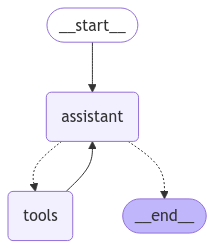

In [39]:
from IPython.display import display, Image
display(Image(graph.get_graph().draw_mermaid_png()))

In [40]:
messages = [HumanMessage(content="Add 3 and 4. Multiply the output by 2. Divide the output by 5")]
messages = graph.invoke({"messages": messages})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Add 3 and 4. Multiply the output by 2. Divide the output by 5
================================== Ai Message ==================================
Tool Calls:
  add (4335b9c8-3681-4a23-8693-4cc8a7cf5a62)
 Call ID: 4335b9c8-3681-4a23-8693-4cc8a7cf5a62
  Args:
    a: 3.0
    b: 4.0
================================= Tool Message =================================
Name: add

7
================================== Ai Message ==================================
Tool Calls:
  multiply (698ef847-860d-499b-b65a-4ea07c27f804)
 Call ID: 698ef847-860d-499b-b65a-4ea07c27f804
  Args:
    a: 7.0
    b: 2.0
================================= Tool Message =================================
Name: multiply

14
================================== Ai Message ==================================
Tool Calls:
  divide (526a3d19-5bc7-4b5f-a178-61060324e586)
 Call ID: 526a3d19-5bc7-4b5f-a178-61060324e586
  Args:
    a: 14.0
    b: 5.0
========